# Dependencies

In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import cm

In [81]:
import numpy as np
import pandas as pd

In [82]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect, and_, desc

# Reflect Tables into SQLAlchemy ORM

In [84]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [86]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Session Guideline
* Design a query to retrieve the last 12 months of precipitation data and plot the results
* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the data and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column
* Sort the dataframe by date
* Use Pandas Plotting with Matplotlib to plot the data

In [89]:
engine.execute("""SELECT *
                    FROM Measurement m
                    GROUP BY 1
                    ORDER BY date desc;
                """).fetchall()[0]

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)

In [90]:
# The measurement column names
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [91]:
# Retrieve the date of the last data point in the database 
last_date_string, = engine.execute("""SELECT m.date
                    FROM Measurement m
                    GROUP BY 1
                    ORDER BY date desc;
                """).fetchall()[0]

last_date = dt.datetime.strptime(last_date_string,'%Y-%m-%d')
print(last_date)

2017-08-23 00:00:00


In [92]:
# Calculate the date 1 year ago from the last data point in the database
one_year_before = last_date - relativedelta(years=1)
print(one_year_before)

2016-08-23 00:00:00


In [93]:
# Extract the date and precipitation data, order by date. 
precipitation_df_raw = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).\
                                filter(Measurement.date>=one_year_before).order_by(Measurement.date).all())
precipitation_df_raw.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [94]:
# Clean up the data and calculate the precipitation mean grouped by date.
precipitation_df_clean = precipitation_df_raw.dropna(how='any')
precipitation_df_agg = precipitation_df_clean.groupby('date').mean().reset_index()
precipitation_df_agg.rename(columns={'prcp':'precipitation'},inplace=True)
precipitation_df_agg.head()

,date,precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [95]:
date_label = []

for row_index,row in precipitation_df_agg.iterrows():
    if row_index % 10 == 0:
        date_label.append(row['date'])

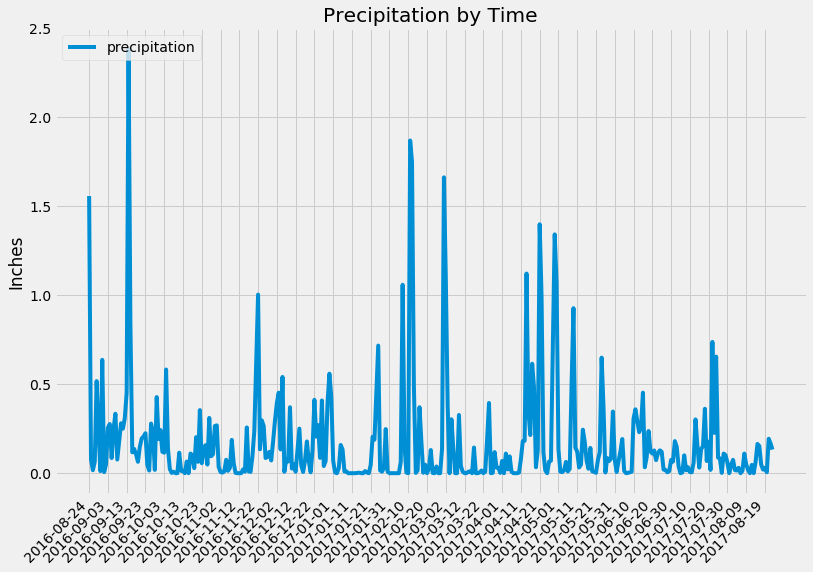

In [96]:
plt.figure(figsize=(12,8))
plt.plot('date','precipitation',data=precipitation_df_agg)

plt.legend(loc=2)
plt.grid(True)
plt.ylabel("Inches")
plt.xticks(np.arange(0,len(precipitation_df_agg),step=10),date_label,rotation=45,ha='right')
plt.title('Precipitation by Time')

plt.savefig("Chart/Prcp_by_time.png")

In [97]:
# Summary of Precipitation Data
precipitation_df_agg.describe()

,precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis

In [98]:
# The station column names
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [99]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.id).count()
num_stations

9

In [100]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_tobs_count = session.query(Measurement.station,func.count(Measurement.tobs)).\
                group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
active_station = station_tobs_count[0][0]
print(f"The most active station is {active_station} with {station_tobs_count[0][1]} of observations")

The most active station is USC00519281 with 2772 of observations


In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for most active station?

tem_min, temp_max, temp_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station==active_station).all()[0]
print (f"The lowest temperature observed is {tem_min}, the highest temperature observed is {temp_max} and average temperature observed is {temp_avg}")

The lowest temperature observed is 54.0, the highest temperature observed is 85.0 and average temperature observed is 71.66378066378067


In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_tobs = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
            filter(Measurement.date>=one_year_before,Measurement.station==active_station).order_by(Measurement.tobs).all()

active_station_tobs_df = pd.DataFrame(data = active_station_tobs,columns=["station","date","tobs"])
active_station_tobs_df.head()

,station,date,tobs
0,USC00519281,2017-02-02,59.0
1,USC00519281,2017-02-08,59.0
2,USC00519281,2017-02-09,59.0
3,USC00519281,2017-02-03,60.0
4,USC00519281,2017-04-30,60.0


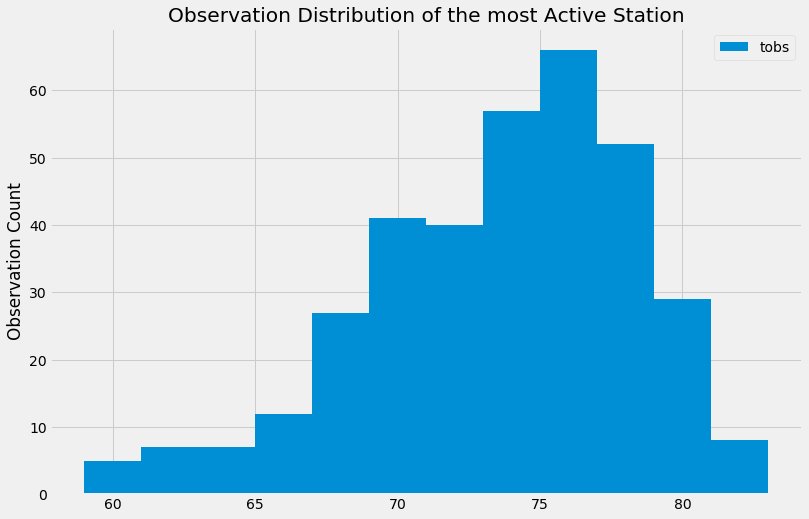

In [103]:
# Plot the results as a histogram with bins=12
plt.figure(figsize=(12,8))

plt.hist('tobs',data = active_station_tobs_df, bins=12)

plt.legend(["tobs"])

plt.title('Observation Distribution of the most Active Station')
plt.ylabel("Observation Count")

plt.grid(True)

plt.savefig("Chart/Observation_Dist.png")

In [104]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [105]:
""" Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
    for your trip using the previous year's data for those same dates. 
    Then plot the error bar"""
    
def plot_prev_temps (trip_start_date,trip_end_date):
    
    prev_trip_start_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - relativedelta(years=1)
    
    prev_trip_end_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - relativedelta(years=1)
    
    temp_min,temp_avg, temp_max = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(and_(Measurement.date >= prev_trip_start_date,Measurement.date <= prev_trip_end_date)).all()[0]
    
    # Plotting
    yerror = temp_max - temp_min

    barvalue = [temp_avg]
    xvals = range(len(barvalue))

    fig,ax = plt.subplots(figsize=(5,8))
    ax.bar(xvals, barvalue, yerr=yerror, color='C2',alpha=0.6)
    ax.set_xticks([1]) 
    plt.ylabel("Temperature")
    plt.title(f"Trip Average Temperature: {trip_start_date} --> {trip_end_date}")
    plt.tight_layout()

    plt.savefig("Chart/Trip_avg_temp.png")

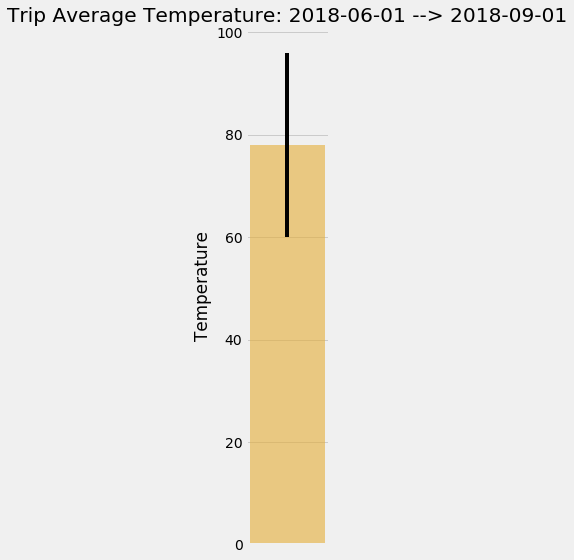

In [106]:
# Try a certain trip period
trip_start_date = '2018-06-01'
trip_end_date = '2018-09-01'
plot_prev_temps (trip_start_date,trip_end_date)

In [107]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prev_rainfall(trip_start_date,trip_end_date):
    
    prev_trip_start_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - relativedelta(years=1)
    prev_trip_end_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - relativedelta(years=1)
    
    rainfall_per_station = session.query(Station.name,Station.station,Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp)).\
                    filter(Measurement.station == Station.station).filter(and_(Measurement.date >= prev_trip_start_date,\
                    Measurement.date <= prev_trip_end_date)).\
                    group_by(Station.station).order_by(desc(func.avg(Measurement.prcp)))
    
    result_dict = []
    for result in rainfall_per_station:
        result_dict.append(result)

    rainfall_per_station_df = pd.DataFrame(data=result_dict,columns=['name','station','lat','lon','elevation','avg_precipitation'])
       
    return rainfall_per_station_df

In [108]:
# Try a certain trip period
trip_start_date = '2018-02-01'
trip_end_date = '2018-09-01'
rainfall_per_station_df = calc_prev_rainfall(trip_start_date,trip_end_date)

rainfall_per_station_df

,name,station,lat,lon,elevation,avg_precipitation
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,0.356105
1,"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,0.222698
2,"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,0.187389
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,0.155765
4,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,0.145793
5,"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,0.092778
6,"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,0.051768


## Optional Challenge Assignment

### Guideline
#### calculate the daily normals for your trip
* push each tuple of calculations into a list called `normals`
* Set the start and end date of the trip
* Use the start and end date to create a range of dates
* Stip off the year and save a list of %m-%d strings
* Loop through the list of %m-%d strings and calculate the normals for each date

#### Analysis and Plot
* Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
* Plot the daily normals as an area plot with `stacked=False`

In [109]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(trip_start_date,trip_end_date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    prev_trip_start_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - relativedelta(years=1)
    prev_trip_end_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - relativedelta(years=1)
    
    trip_date_all = session.query(Measurement.date).\
                    filter(and_(Measurement.date >= prev_trip_start_date,\
                    Measurement.date <= prev_trip_end_date)).distinct()

    daily_normals_dict = []
    
    for date, in trip_date_all:
    
        month_day = date.split('-', maxsplit=1)[1]

        temp_max,temp_min,temp_avg = session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),\
                        func.avg(Measurement.tobs)).filter(Measurement.date.like("%"+month_day)).all()[0]

        daily_normals_dict.append({'date':month_day,'max_temp':temp_max,'min_temp':temp_min,'avg_temp':temp_avg})
        
    daily_normals_df = pd.DataFrame(daily_normals_dict)
    
    return daily_normals_df

In [110]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_start_date = '2018-02-01'
trip_end_date = '2018-09-01'
daily_normals_df = daily_normals(trip_start_date,trip_end_date)

daily_normals_df.head()

,avg_temp,date,max_temp,min_temp
0,68.859649,02-02,77.0,59.0
1,67.796610,02-03,77.0,58.0
2,68.140351,02-04,76.0,61.0
3,69.684211,02-05,80.0,59.0
4,70.389831,02-06,77.0,58.0


In [111]:
date_label = []

for row_index,row in daily_normals_df.iterrows():
    if row_index % 10 == 0:
        date_label.append(row['date'])

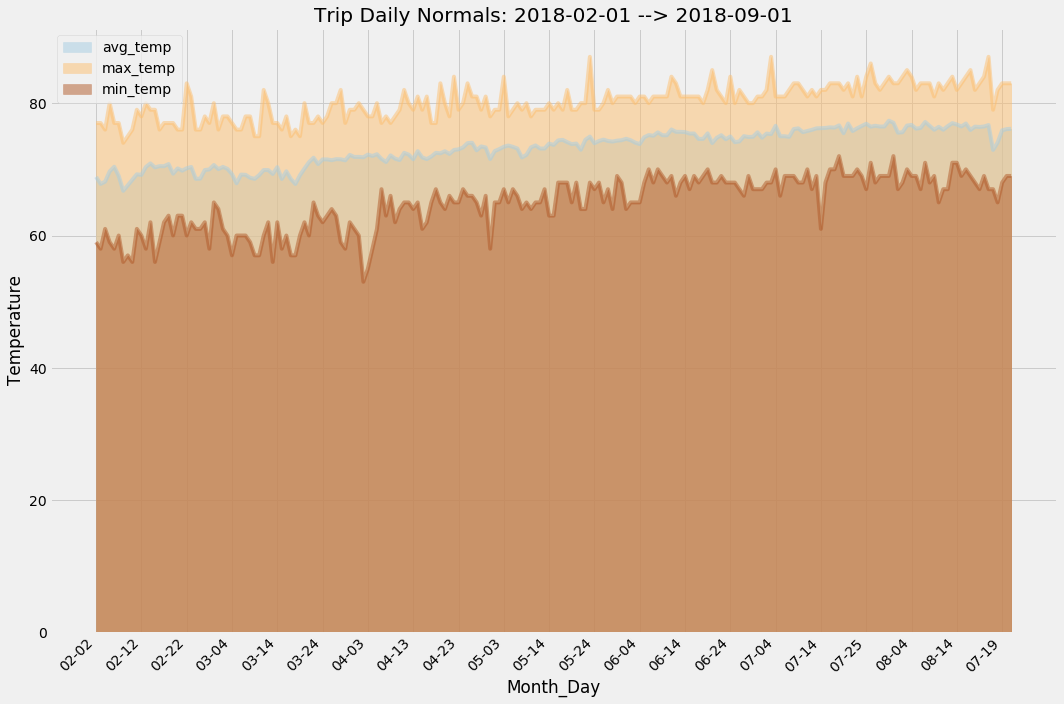

In [112]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area',stacked=False,figsize=(15,10),alpha=0.50,cmap = cm.get_cmap('Paired'))

plt.xticks(np.arange(0,len(daily_normals_df),step=10),date_label,rotation=45,ha='right')

plt.xlabel("Month_Day")
plt.ylabel("Temperature")
plt.title(f"Trip Daily Normals: {trip_start_date} --> {trip_end_date}")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("Chart/Trip_daily_normals.png")